In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import RidgeCV
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# Model Prototyping
<a id='toc'></a>
# Table of contents

## [1. Introduction](#intro)
## [2. Data](#data)
## [3. Fully connected Neural Network](#NN)
## [4. Convolutional Neural Network](#cnn)
## [5. Ridge Regression](#regression)
## [6. Analysis and preliminary conclusion](#conclusion)

<a id='intro'></a>
# 1. Introduction
[Return to table of contents](#toc)

The goal of this notebook is to get a feel for the performance of the two different types of models to be trained.
Specifically, comparison will be made between a naive baseline model, a ridge regression model, and a convolutional neural network model. Because this notebook is simply prototyping, a very small subset of the available data will be used; a single 
feature's time series for a single country, the United States. This single feature is all that will be available to the CNN and Ridge regression models; because eventually the feature data used in the regression is much larger than that used in the CNN training, this might be an unfair comparison.

The main issue for using a very small subset of data is that I believe it will negatively affect the neural networks more than the regression, but this notebook is to mainly get a feeling for the Keras API and how the data must be formatted.   
I debated between using MAE vs. MSE but decided it would be better to account for outliers during the preprocessing phase rather than using MAE. I use ridge regression as opposed to say, Lasso, because there will not be many features used and so the added benefit of feature selection via the $L_1$ norm is really as useful. Usage of the non-default scoring for Ridge means I have to use RidgeCV, which means I need to provide my own folds in order to respect time ordering.

In [2]:
def country_slice(data, locations):
    # used as convenience function with pandas
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    # used as convenience function with pandas, used to slice custom time index
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    # plot time series for all countries
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    # plot Series for all times (not useful, I meant to do something else)
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def column_search(df, name, return_style='loc', threshold='contains'):
    # Due to redundant data and large number of columns, remembering the
    # exact names can be a chore. 
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def residual_plot(y_test, y_predict, title='', ax=None):
    # plot the residuals
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=20,alpha=0.7)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_frame in range(start_date, time_index.max() - n_days_into_future + 2):
        frame_data = model_data[(time_index <= max_date_in_frame-1) & 
                                (time_index >= max_date_in_frame-frame_size)]
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)

        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_frame == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_frame-frame_size, max_date_in_frame - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_frame-frame_size, max_date_in_frame - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def flatten_Xy_splits(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict, n_countries, title='',suptitle='',figname=None, scale=None, s=None):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    # compute scores 
    mse_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_naive, r2_predict))

    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    
    ax1.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_naive,3)),fontsize=14)
    ax1.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_naive,3)),fontsize=14)
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')
             
    ax2.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_predict,3)),fontsize=14)
    ax2.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_predict,3)),fontsize=14)
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)

    
    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    ax3.set_title('')
    ax4.set_title('')
    ax3.set_ylabel('Residual')
    ax4.set_ylabel('Residual')
    ax3.grid(True)
    ax4.grid(True)
    
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
        
    plt.show()
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

In [3]:
# Import cleaned data produced by other notebook. 
global_data = pd.read_csv('cnn_data.csv',index_col=0)

For the prototyping of the neural networks I will only use a single time series, new cases per million, for a single country, the United States.

In [4]:
data = global_data[global_data.location=='United States'].reset_index(drop=True)
data = data.drop(columns=['date'])

<a id='data'></a>
# 2. Data
[Return to table of contents](#toc)

There are five main steps in the data preprocessing stage.
    
    1. Feature selection
    2. Creation of time frames
    3. Splitting the data into different sets for validation
    4. Rescaling of the data
    5. Reshaping to abide by keras/scikit-learn conventions 

### 2.1 Feature Selection

This does not really play a role in this notebook because I am prototyping using only a single feature for the neural networks. For the regression this is different and so I will explain my rationale in regards to feature selection. I do not use quantitative means for feature selection (No recursive feature elimination, PCA, etc.) rather I use a qualitative argument for my choices, but I will leave that for the main model creation notebooks.

In [5]:
# Single out the only feature used for the prototyping.
model_data = data.copy().loc[:, 'new_cases_per_million'].to_frame()
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0

# query some parameters to be used for convenience and formatting.
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

# get the start date for the frames, and the frame size
frame_size = 28
start_date = frame_size + data.time_index.min()

# determine the size of the splits 
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

### 2.2 Creation of time-frames

The data will be formatted in the following manner for both the neural networks and the regression models. 
The original table format of the data is that each row of the table ```data``` (DataFrame, technically) contains
a single day's information for a single country. In order to better suit the time series nature of the features utilized, I will increase the dimension (columns) of each sample by concatenating multiple days worth of data. Specifically, I format the data such that each row is comprised of 28 days of feature day for a single country. Hereafter I refer to this concatenation of 
multiple time steps as 'frames' of time, or simply time frames. These can be thought of as sliding a step-function window across the feature data to create a collection of time frames. In the splitting of the data into different sets, I identify each frame by its most recent date. 

To help the reader understand this concept, I include a hand drawn image of this. 

<div>
<img src="time_frames.jpg" width="500"/>
</div>

By iterating over possible leading window dates a 4-d tensor with dimensions given by the following is created:

```X.shape = (n_frames, n_countries, n_time_steps, n_features)```


In [6]:
# split the data
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 154 181



### 2.3. Splitting the data into train, validate, test.
Now, splitting X intro train, validate, test, is as easy as slicing the first axis. 
Going backwards in time, the testing set contains the next to last most recent day's worth of values. It's not
the last day because the last day has no "future" with which to compare, and so no worthwhile prediction can be
made. The test set is defined by slicing X for its last row(s) (plural if n_test_frames > 1). The validation set that will 
be used is the next 7 days worth of values and the training data is everything else.

The keras API expects a three dimensional tensor, and so after the slicing/partitioning into different sets, the first axis
is concatenated such that the effect dimensions are ```(n_frames*n_countries, n_time_steps, n_features)```.
This is done via the function ```flatten_Xy```. Technically, when initializing the model it expects a 2-d shape. This is because the data is organized as ```(batch_size, time_steps, features)```. In other words, when initializing the model, one gives the api a shape of a single sample. This is visualized in the image below. 

In [7]:
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

<div>
<img src="3d_tensor_input.jpg" width="300" height="300">
</div>

### 2.4. Rescaling

The fourth preprocessing step is to rescale the data, For this purpose, I will use MinMax scaling, except instead of using the maximum values in the training set I instead create some arbitrary maximum and
use this to rescale values to the interval [0, 1] (such that the fictitious maximum equals 1, I elect to use twice the maxima of the training sets). The use of this arbitrary maximum is to account for the possibility of future growth. 
The reasons why MinMax scaling is used: all of the independent variables take non-negative values and so maintaining this property helps interpretability. The numerical reason is because of how neural networks typically respond negatively to wide ranges of scales, because it can make weights large in magnitude.   

In [8]:
# Rescale the data 
scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_nn_train, y_nn_train, X_nn_validate, y_nn_validate, X_nn_test, y_nn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

### 2.5. Reshaping

And finally, the last preprocessing step is to reshape the data to abide by the various conventions.
For the Keras API, the (1d) convolutional layers expect a tensor of the shape (trying to stick to their notation)

```Conv1d_input_shape = (batch_size, time_steps, n_features)``` .

In this instance, batch size represents a collection of samples: the individual time frames for each country. Therefore if it helps, the batch is a collection of time frames, even one iterated through the batch sequentially, it would produce a collection of slide shows, one for each country. This can be achieved by simply collapsing the first axis such that 

```(n_frames*n_countries, n_time_steps, n_features)``` is the final shape of a 3-d tensor.


For the Ridge regression we must go one step further, as it expects a matrix, or 2-d array, for the set of predictors. Each
frame will represent a row of this matrix, such that by combining the last two axes, we get the correct form. In other words, the final shape is to be 

```(n_frames*n_countries, n_time_steps*n_features)``` is the final, two-dimensional shape.

In [9]:
# collapse the time axis used for slicing
X_nn_train_model = np.concatenate(X_nn_train.reshape(X_nn_train.shape[0], 
                                                     X_nn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_nn_validate_model = np.concatenate(X_nn_validate.reshape(X_nn_validate.shape[0], 
                                                           X_nn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_nn_test_model = np.concatenate(X_nn_test.reshape(X_nn_test.shape[0], 
                                                   X_nn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
# reshape the dependent variable
y_nn_train_model = y_nn_train.ravel()
y_nn_validate_model = y_nn_validate.ravel()
y_nn_test_model = y_nn_test.ravel()

In [10]:
print('In the data that will be used for training my prototype models, there are:')
print(X.shape)
print('A total of {} frames'.format(X.shape[0]))
print('A total of {} countries'.format(X.shape[1]))
print('A total of {} time steps in each frame'.format(X.shape[2]))
print('A total of {} features'.format(X.shape[3]))

In the data that will be used for training my prototype models, there are:
(155, 1, 28, 1)
A total of 155 frames
A total of 1 countries
A total of 28 time steps in each frame
A total of 1 features


To ensure that the data has been split correctly and is aligned with the original values, I plot the scaled data's splits based on color, as well as the original supposed order. The order of the values is correct if the original values are black circles directly behind the colored train-validate-test splits circles'.

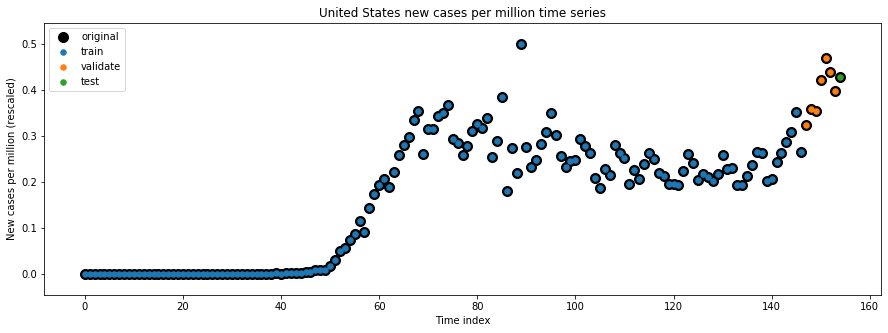

In [11]:
# Preview the time series and its split. 
X_scaled_tmp = np.concatenate((X_nn_train,X_nn_validate,X_nn_test), axis=0)
usa_indices = np.where(data.location.unique()=='United States')[0]
fig, ax = plt.subplots(1,1, figsize=(15,5))

# plot the original data before slicing 
ax.scatter(range(len(X_scaled_tmp)), X_scaled_tmp[:, usa_indices, -1, new_cases_index], s=100, color='k', label='original')

# training set plot
ax.scatter(range(len(scaled_splits[0])), 
           scaled_splits[0][:, usa_indices,-1, new_cases_index]
           , s=30, label='train')

# validation set
ax.scatter(range(len(scaled_splits[0]), len(scaled_splits[0])+len(scaled_splits[2])), 
            scaled_splits[2][:, usa_indices,-1, new_cases_index]
           , s=30, label='validate')

# testing set
ax.scatter(range(len(scaled_splits[0])+len(scaled_splits[2]), len(X)), 
            scaled_splits[4][:, usa_indices,-1,new_cases_index]
           , s=30, label='test')

plt.legend()
plt.title('United States new cases per million time series')
plt.ylabel('New cases per million (rescaled)')
plt.xlabel('Time index')
_ = plt.show()

Scatter plots of train, validate, test sets, by plotting all values in black first I can ensure that the points
are correctly ordered and at the correct values because it makes the rest of the points look like they have black borders.

To get the correct arrays for the naive baseline, take the values from X instead of y, as y is shifted and makes the process more confusing and or susceptible to mistakes.

<a id='NN'></a>
# 3. Fully connected neural network model
[Return to table of contents](#toc)

For the purpose of this project I will maintain a constant architecture for the neural networks and mainly perform tuning via the parameters therein. Investigations of new architectures are left for future work. The neural network architecture is drawn in the following figure.

<div>
<img src="nn.jpg" width="600" height="300">
</div>

The output is a single number, the predictive output for the number of new cases.

In [12]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))

# Get the naive baseline values for each split
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

For reproducibility set the seeds of the weights in the model.

In [13]:
kernel0 = RandomNormal(seed=0)
kernel1 = RandomNormal(seed=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Initialize, compile the neural network, readying it for fitting 

In [14]:
epochs = 2000
batch_size = 32

nn_input = Input(shape=X_nn_train.shape[2:])
flat = Flatten()(nn_input)
dense0 = Dense(int(flat.shape[1].value), 
                use_bias=False,
               kernel_initializer=kernel0,

               )(flat)
dense1 = Dense(1, 
                activation='relu',
                use_bias=False,
                kernel_initializer=kernel1,

               )(dense0)

nn = Model(inputs=nn_input, outputs=dense1)
nn.compile(loss='mae', optimizer=Adam())

Check the number of parameters to see that there are not too many (as there are not many samples)

In [15]:
nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 1)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 28)                0         
_________________________________________________________________
dense (Dense)                (None, 28)                784       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 28        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________


Fit the model to the scaled training and validation data. 

In [16]:
history = nn.fit(X_nn_train_model, y_nn_train_model, epochs=epochs, validation_data=(X_nn_validate_model, y_nn_validate_model), 
          batch_size=batch_size, verbose=0)

Look at the training and validation loss vs epochs, to see if the model has been overtrained.

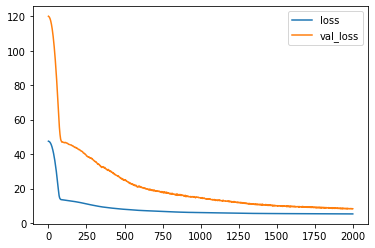

In [17]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

After fitting the data, look at some plots which compare the predictions for both the neural network and naive baseline vs the true values; first for the training and then the validation set.

There were 0 negative predictions
1-step MSE [Naive, NN model] = [170.6373859727891,105.94464113034005]
1-step R^2 [Naive, NN model] = [0.8824581415815376,0.9278192907706263]


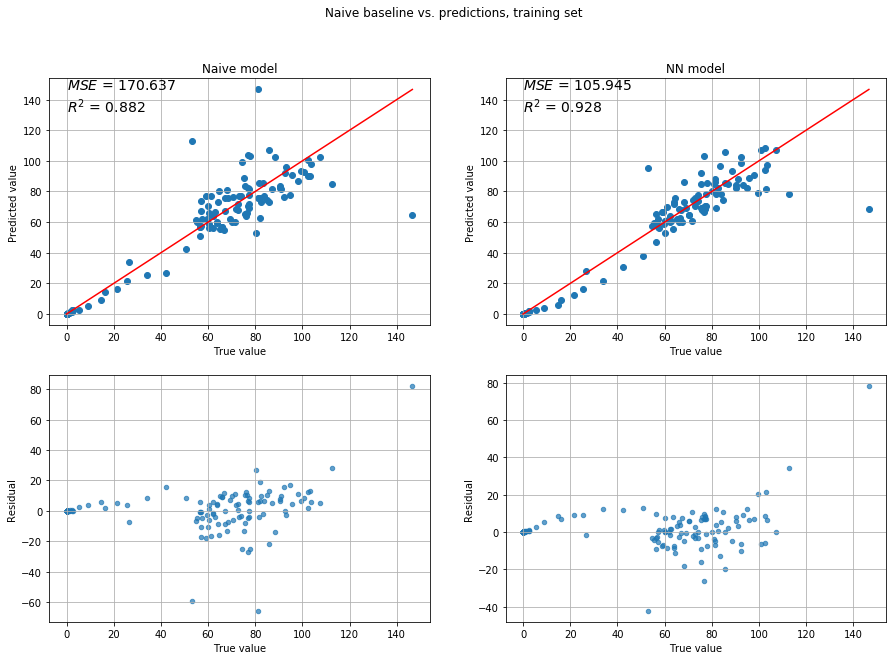

In [18]:
y_true =  y_nn_train_model.ravel()
y_predict = nn.predict(X_nn_train_model).ravel()
y_naive = y_train_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='NN model',
               suptitle='Naive baseline vs. predictions, training set',
              figname='nn_prototype_train_performance.jpg')

There were 0 negative predictions
1-step MSE [Naive, NN model] = [140.7995238571429,115.54207661640815]
1-step R^2 [Naive, NN model] = [0.07977244339484346,0.36137561707109034]


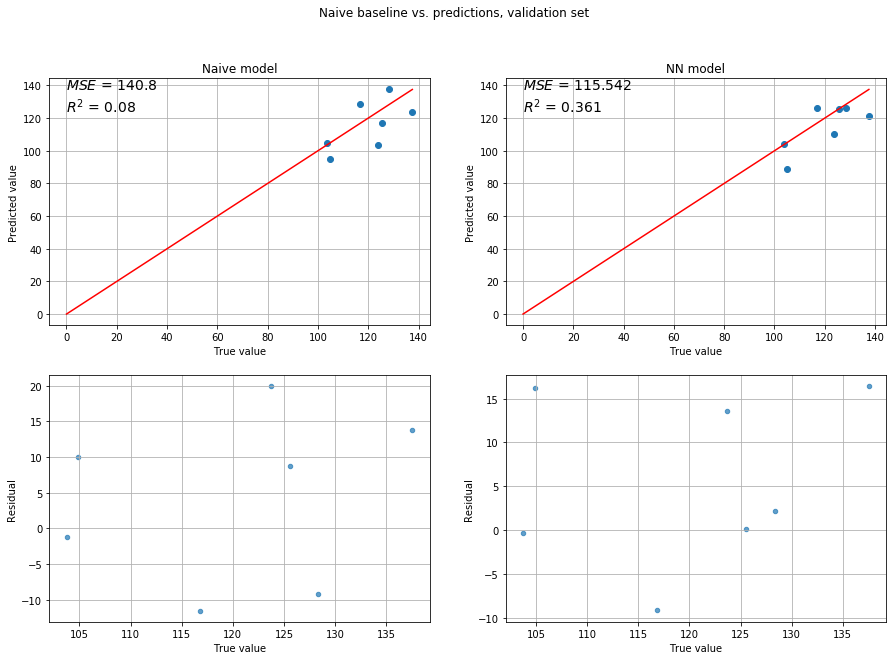

In [19]:
y_true =  y_nn_validate_model.ravel()
y_predict = nn.predict(X_nn_validate_model).ravel()
y_naive = y_validate_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='NN model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='nn_prototype_validate_performance.jpg')

<a id='cnn'></a>
# 4. Convolutional neural network model
[Return to table of contents](#toc)

The convolution is with respect to time, specifically the time steps within frames of time of predetermined length. The idea behind usage of a convolutional neural network is to have the network identify the relevant patterns in the dataset. This brings along with it a number of important details is indeed in the right dimension and that time-ordering is being respected by the training and validation process. The manner in which this is handled also has to be compatible with the keras API. The preprocessing is the same as that for the neural network, only that this time the input is not flattened until after the convolutional layers. So, proceeding as before, ***I do some redundant calculations here for the sake of modularity.***

In [20]:
# Single out the only feature used for the prototyping.
model_data = data.copy().loc[:, 'new_cases_per_million'].to_frame()
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0

# query some parameters to be used for convenience and formatting.
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

# get the start date for the frames, and the frame size
frame_size = 28
start_date = frame_size + data.time_index.min()

# determine the size of the splits 
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [21]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = splits
(train_indices, validate_indices, test_indices) = indices

X_cnn_train_model = np.concatenate(X_cnn_train.reshape(X_cnn_train.shape[0],
                                                       X_cnn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_validate_model = np.concatenate(X_cnn_validate.reshape(X_cnn_validate.shape[0],
                                                             X_cnn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_test_model = np.concatenate(X_cnn_test.reshape(X_cnn_test.shape[0],
                                                     X_cnn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_cnn_train_model = y_cnn_train.ravel()
y_cnn_validate_model = y_cnn_validate.ravel()
y_cnn_test_model = y_cnn_test.ravel()

X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 154 181


The architecture of the CNN itself is two convolutional layers followed by two dense layers, ending with a ReLU activation layer. The parameters for the convolutional layers are the number of filters and the kernel size of the convolutions. The number of filters is much larger than the second because the desire is to pick up on many small patterns and then use them in combination to form larger ones. As far as I know this is the best way of doing so. There is no real argument for the convolutional kernel size other than they cannot be too large because the number of time steps are themselves small in number. 

Here is the visualization of this architecture.

<div>
<img src="cnn.jpg" width="600" height="300">
</div>


Initialize with seeds for reproducibility, follow the same procedure as the neural network

In [22]:
kernel0 = RandomNormal(seed=0)
kernel1 = RandomNormal(seed=1)
kernel2 = RandomNormal(seed=2)
kernel3 = RandomNormal(seed=3)

In [23]:
epochs = 1000
kernel = 4
N = 8
FC = 8
batch_size = X_cnn_train.shape[0]

f1, f2 = 64, 4
k1, k2 = 4, 4

cnn = Sequential()


cnn.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
               kernel_initializer=kernel0,
                )
         )

cnn.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
               kernel_initializer=kernel1,
                )
         )

cnn.add(Flatten())


cnn.add(Dense(4,
              kernel_initializer=kernel2,
             )
       )


cnn.add(Dense(1, 
                activation='relu',
              kernel_initializer=kernel3,

                   ))

cnn.compile(loss='mae', optimizer=Adam())

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


In [24]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25, 64)            320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 4)             1028      
_________________________________________________________________
flatten_1 (Flatten)          (None, 88)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 356       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,709
Trainable params: 1,709
Non-trainable params: 0
_________________________________________________________________


Fit the model.

In [25]:
history = cnn.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=0)

Plot the training and validation loss curves to check for overfitting.

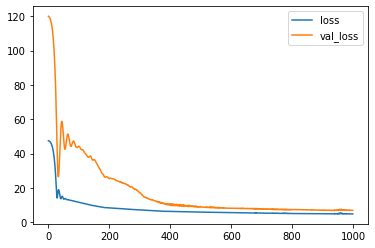

In [26]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

Plot the results of predicting the training set.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.6373859727891,109.76413402693512]
1-step R^2 [Naive, CNN model] = [0.8824581415815376,0.9243683107232408]


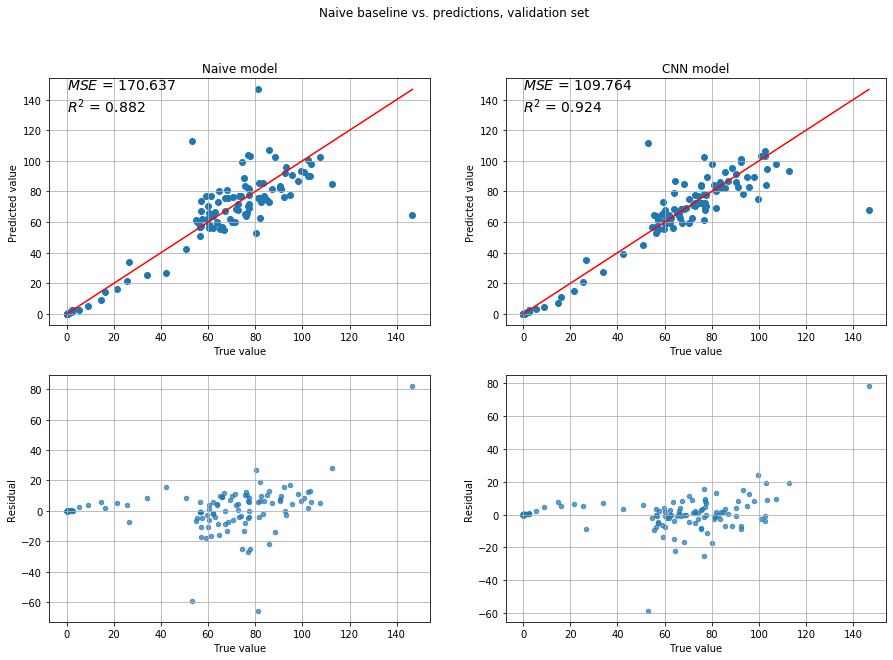

In [27]:
y_true = y_cnn_train_model.ravel()
y_predict =  cnn.predict(X_cnn_train_model).ravel()
y_naive = y_train_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='CNN model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='cnn_prototype_train_performance.jpg')

Plot the results of predicting the validation set.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [140.7995238571429,66.27978083734835]
1-step R^2 [Naive, CNN model] = [0.07977244339484346,0.5014974396024214]


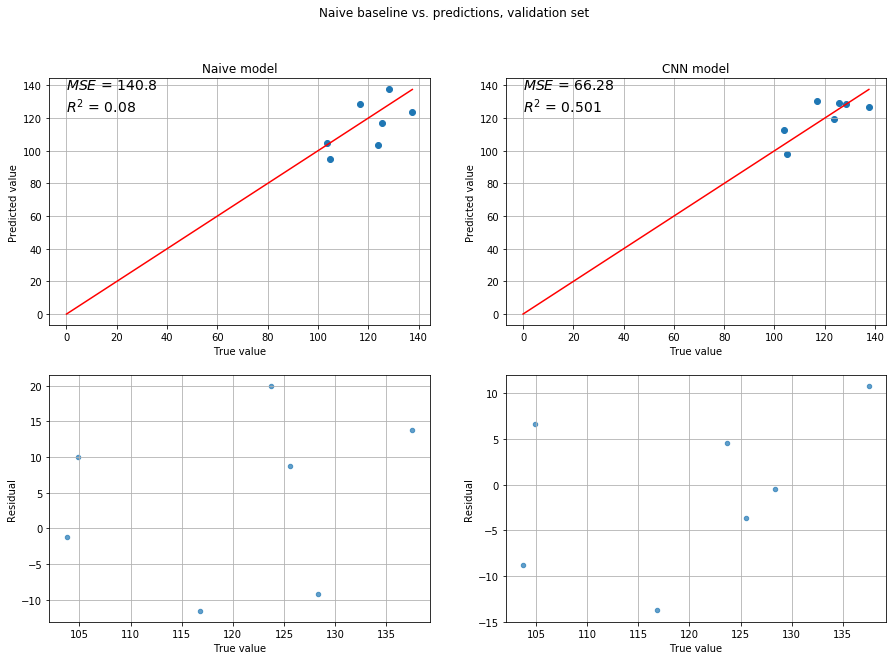

In [28]:

y_true =  y_cnn_validate_model.ravel()
y_predict = cnn.predict(X_cnn_validate_model).ravel()
y_naive = y_validate_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='CNN model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='cnn_prototype_validate_performance.jpg')

A summary of the network for convenience.

<a id='regression'></a>
# 5. Ridge Regression 

## 5.1 Univariate regression
[Return to table of contents](#toc)

The last model used is Ridge regression, or linear regression with $L_2$ regularization. I will actually deploy this model on two different subsets in this prototyping stage. The first subset is the same which is used for the neural networks which is to say only the ```new_cases_per_million``` feature. For the regression I start with this same data for comparison, but then expand into the realistic scenario wherein there are multiple features. 

In [29]:
r_data = pd.read_csv('regression_data.csv', index_col=0)
tmp = pd.read_csv('regression_data_full.csv', index_col=0)
r_data = pd.concat((r_data,tmp.loc[:, column_search(tmp,'government_response')]),axis=1)
r_data = r_data.drop(columns=['date'])
r_data = r_data.drop(columns=column_search(r_data,'test'))
r_data = r_data.drop(columns=column_search(r_data,'deaths'))
r_data = r_data.drop(columns=column_search(r_data,'recovered'))
r_data = r_data.drop(columns=column_search(r_data,'std'))
r_data = r_data[r_data.location == 'United States']

Again for the sake of modularity, perform some redundant calculations.

In [30]:
modeling_features = ['new_cases_per_million', 'government_response_index', 'log_new_cases_per_million']
model_r_data = r_data.copy().loc[:, modeling_features]

In [31]:
r_model_data = r_data.new_cases_per_million.to_frame().copy(); new_cases_index=0
new_cases_index = column_search(r_model_data, 'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size + time_index.min()
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [32]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)

y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 154 181


In [33]:
X_regression_train.shape

(147, 28)

I want to use a different metric other than explained variance as a metric; the easiest way of doing so is to use RidgeCV and pass it a scoring function. I also provide the indices of the training and testing folds; of which there is only one, so that the data used to train this model and the neural networks are the same. The cross validation ranges over some alpha values (regularization constant).

In [34]:
X_regression = np.concatenate((X_regression_train, X_regression_validate), axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate), axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge.fit(X_regression, y_regression)

The predictions of the training set.

There were 0 negative predictions
1-step MSE [Naive, Ridge Regression model] = [170.6373859727891,86.72651408412848]
1-step R^2 [Naive, Ridge Regression model] = [0.8824581415815376,0.9401393173616021]


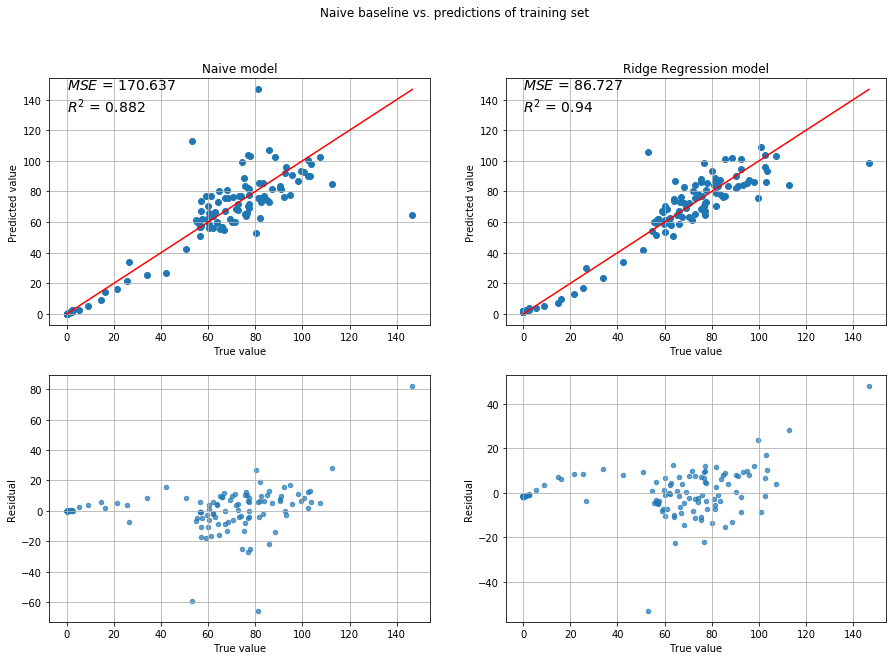

In [35]:
y_true = y_regression_train
y_predict = ridge.predict(X_regression_train).ravel()
y_naive = y_train_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge Regression model',
               suptitle='Naive baseline vs. predictions of training set',
              figname='regression_prototype_single_train_performance.jpg')

The predictions of the validation set.

There were 0 negative predictions
1-step MSE [Naive, Ridge Regression model] = [140.7995238571429,94.37377616649768]
1-step R^2 [Naive, Ridge Regression model] = [0.07977244339484346,0.41144250051125075]


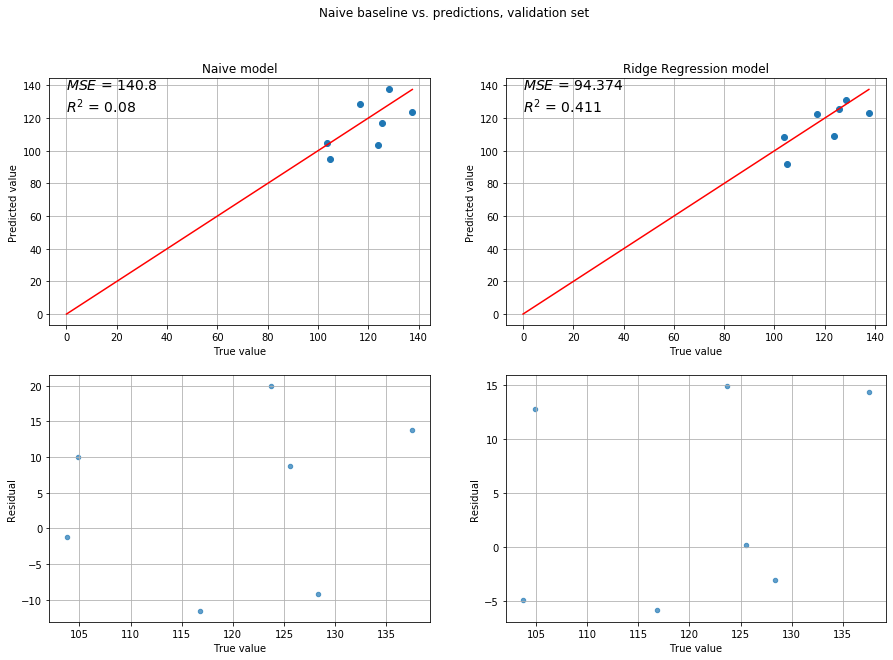

In [36]:
y_true = y_regression_validate
y_predict = ridge.predict(X_regression_validate).ravel()
y_naive = y_validate_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge Regression model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='regression_prototype_single_validate_performance.jpg')

## 5.2 Multivariate regression
[Return to table of contents](#toc)

This second regression model contains most of the time-dependent features as well as their corresponding rolling averages.

This is partly a sneak peak into the notebook on regression, ```COVID19_regression.ipynb``` and partly a demonstration of evidence that supports the claim that regression performs much better with more feature information. ***Again, redundant calculations are performed for modularity.***

In [37]:
r_model_data = r_data.iloc[:,2:].copy()
new_cases_index = column_search(r_model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [38]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices

(X_train, y_train, X_validate,
 y_validate, X_test, y_test) = splits

n_features = X.shape[-1]
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 154 181


Before we proceed, let's check that the data is organized as we expect, as this time around we are using more than a single feature. First, get the indices of the 28 columns which we expect to represent 28 days of new case values.

In [39]:
new_cases_indices = np.ravel_multi_index([list(range(frame_size)),[new_cases_index]],(frame_size, n_features))
new_cases_indices

array([  1,  19,  37,  55,  73,  91, 109, 127, 145, 163, 181, 199, 217,
       235, 253, 271, 289, 307, 325, 343, 361, 379, 397, 415, 433, 451,
       469, 487], dtype=int64)

In [40]:
flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

In [41]:
# The first frame should have time values from 0 to 27.
r_model_data.new_cases_per_million.iloc[:frame_size].values-X_regression_train[0, new_cases_indices]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [42]:
# The last row or last frame, should have values from time_index.max()-1-n_test_frames-n_validation_frames-frame_size to time_index.max()-1-n_test_frames-n_validation_frames
(r_model_data.new_cases_per_million.iloc[-frame_size-n_test_frames-n_validation_frames-1:-n_test_frames-n_validation_frames-1].values
 -X_regression_train[-1, new_cases_indices])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Now that the data is at least ordered how I expect, proceed with the modelling.

In [43]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge_all_features = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge_all_features.fit(X_regression, y_regression)

As previously seen, predict on the training and validation data.

There were 23 negative predictions
1-step MSE [Naive, Ridge Regression model] = [170.6373859727891,31.998758903177688]
1-step R^2 [Naive, Ridge Regression model] = [0.8824581415815376,0.9779122443046875]


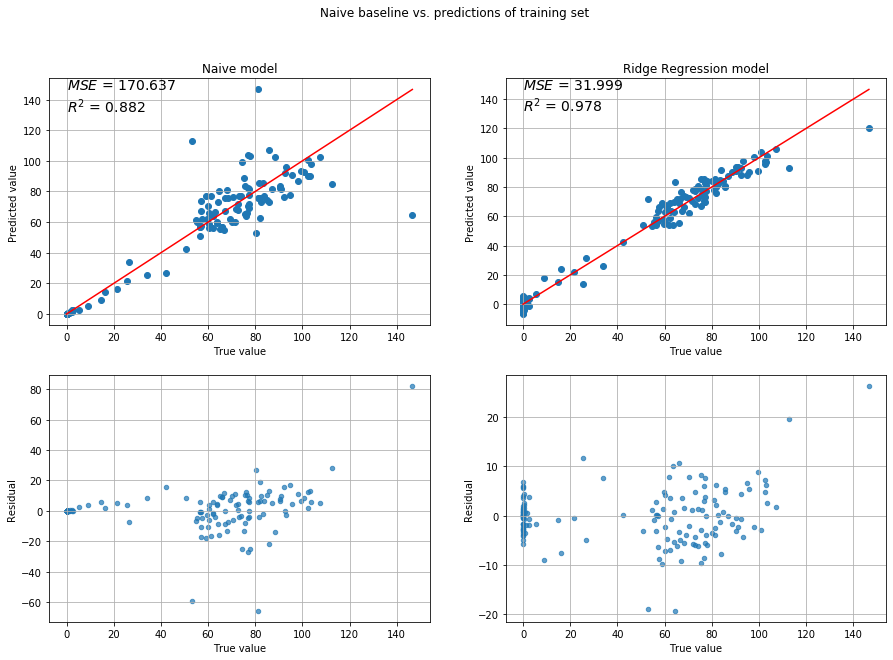

In [44]:
y_predict = ridge_all_features.predict(X_regression_train).ravel()
y_true = y_regression_train
y_naive =y_train_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge Regression model',
               suptitle='Naive baseline vs. predictions of training set',
              figname='regression_prototype_train_performance.jpg')

There were 0 negative predictions
1-step MSE [Naive, Ridge Regression model] = [140.7995238571429,54.73039758422447]
1-step R^2 [Naive, Ridge Regression model] = [0.07977244339484346,0.6250557611631351]


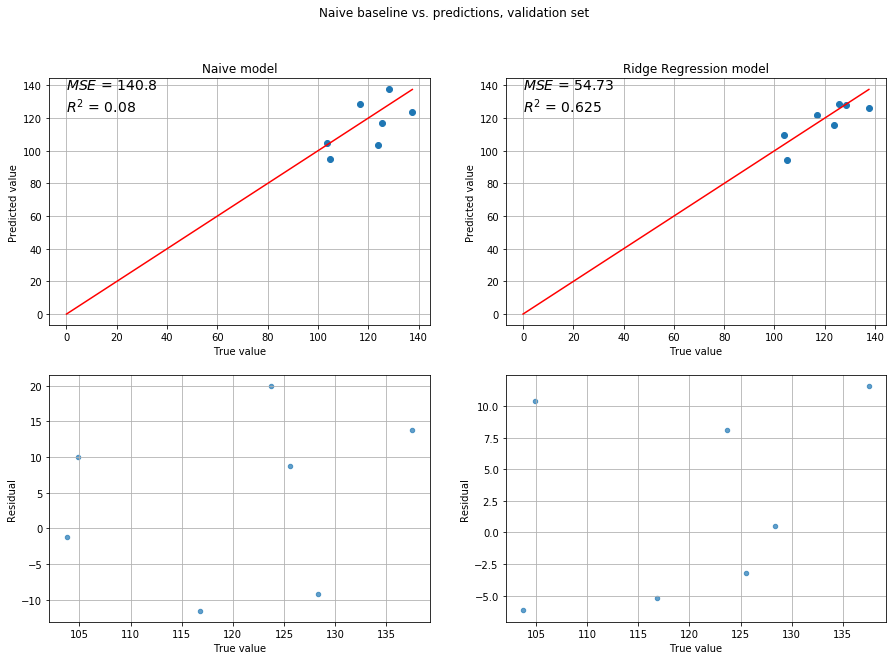

In [45]:
y_true = y_regression_validate
y_predict = ridge_all_features.predict(X_regression_validate).ravel()
y_naive = y_validate_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='Ridge Regression model',
               suptitle='Naive baseline vs. predictions, validation set',
              figname='regression_prototype_validate_performance.jpg')

<a id='conclusion'></a>
## 6. Analysis and conclusion
[Return to table of contents](#toc)

As a final measure of the potency of each prototype model, perform predictions on the test data. Because these models are only using a single countries data, I do not view this as snooping the holdout set.

In [46]:
y_naive = y_test_naive
y_true = y_test
y_predict_r = ridge_all_features.predict(X_regression_test)
y_predict_c = cnn.predict(X_cnn_test_model)
y_predict_n = nn.predict(X_nn_test_model)

While the ridge regression trained on all of the feature data performs very well on the training and validation sets, it does not perform well on the testing set. Presumably this is because I did not retrain the data on the combination of training and validation; i.e. it is using a model which is only trained up to a week into the past. I find this sufficient for these prototype models, however.

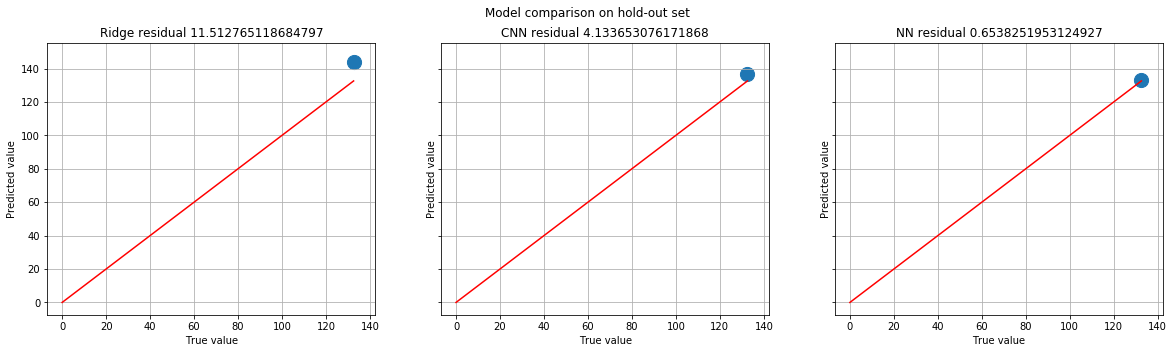

In [47]:
s = 200
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5),sharey=True)

ymax = np.max([y_true.max(), y_predict.max()])
ax1.plot([0, ymax], [0, ymax],color='r')
ax1.scatter(y_true, y_predict_r, s=s)
ax2.plot([0, ymax], [0, ymax],color='r')
ax2.scatter(y_true, y_predict_c, s=s)
ax3.plot([0, ymax], [0, ymax],color='r')
ax3.scatter(y_true, y_predict_n, s=s)

ax1.set_xlabel('True value')
ax1.set_ylabel('Predicted value')
ax1.set_title('Ridge residual '+str(y_predict_r.ravel()[0]-y_true.ravel()[0]))

ax2.set_xlabel('True value')
ax2.set_ylabel('Predicted value')
ax2.set_title('CNN residual '+str(y_predict_c.ravel()[0]-y_true.ravel()[0]))

ax3.set_xlabel('True value')
ax3.set_ylabel('Predicted value')
ax3.set_title('NN residual '+str(y_predict_n.ravel()[0]-y_true.ravel()[0]))

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
plt.suptitle('Model comparison on hold-out set')
plt.show()